### Problem statement/ proposed solution metrics

In this notebook, we will attempt to address the problem task at hand defined by PASSNYC:
* There is a vast ethnic disparity in the percentage of registering for/ clearing SHSAT and hence resulting lack of diversity in the specialized high schools which offer admissions based on the results of SHSAT.
* Analyse the cause for the low percentage of black/ hispanic students clearing the test and suggest solutions which can help bring more diversity into these specialized high schools. These would include <br>
 a) Identifying schools with students eligible for SHSAT <br>
 b) Identifying possible reasons for undderperformance/ non appearance in SHSAT <br>
 c) Pinpointing the key improvements needed in those schools <br>
 d) Explaining the rational/ statistics behind those decisions <br>

### Notable facts
Some facts about SHSAT which will be explain the relevance of the problem and wouldl be helpful in understanding the observations posted below:
* Specialized High Schools Admissions Test is the admissions criterion for eight of the nine specialized high schools
* Students of class 8 and 9 are eligible to appear in the test
* There are two SHSAT sections: English Language Arts (ELA) and Math
* The three highest-status schools—Stuyvesant, Bronx Science, and Brooklyn Tech—have black and Latino student populations of 4, 9, and 13 percent, respectively, far below the 70 percent in public schools citywide.
* The only way to register for the SHSAT is through your middle school guidance counselor. 

### References
[This article](https://www.theatlantic.com/education/archive/2018/06/new-york-high-schools-stuyvesant-brooklyn-bronx/562772/) is a very good read for people who wish to understand the problem in more detail and how it came into being


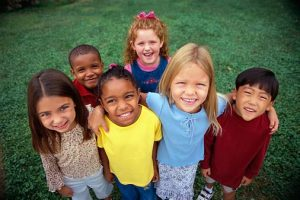

### About the dataset
2 files available
1. <b> 2016 School Explorer.csv </b> : 1272 rows, each describing a separate school in terms of its 161 features which include 
    * Locality information (Lat/ Long/ ZIP/ Address/ City (45 unique cities) / District (32)/ SED code (unique to school) )
    * Students of each ethnicity registered in ELA/ Maths in different grades
    * School evaluation metrics
    * ELL information
    * 
    
2. <b> D5 SHSAT Registrations and Testers.csv </b> : Contains information on the students of 30 schools of district 5 who registered for/ actually appeared for SHSAT, along with the breakdown by ethnicity.
 

### First things first. 

Our primary focus in this notebook is on the reasons for poor performace in SHSAT for which grade 8/9 students are eligible. Of the dataset of 1272 schools that was made available, only 619 schools have classes beyond grade 5. So, for now we will focus on schools which have students eligible for SHSAT.  We understand that the other schools are also relevant as they provide the primary education on which the next ones build but we will come to those later on in the notebook.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df_schools_raw = pd.read_csv('2016 School Explorer.csv')

df_schools_raw = df_schools_raw[df_schools_raw['Grade High'] != '0K']
df_schools_relevant_grade = df_schools_raw[df_schools_raw['Grade High'].astype(int) > 5]

high_nan_columns = df_schools_raw.columns[df_schools_raw.isnull().mean()>0.95]
# print("Here are the fields having >95% NaNs which we can drop: \n")
# print(list(high_nan_columns))

df_schools = df_schools_relevant_grade.drop(high_nan_columns, axis=1)
print("We have %d relevant schools and %d fields describing the school/ students"%(df_schools.shape))

We have 626 relevant schools and 158 fields describing the school/ students


### Attacking the absent ratio



Text(0.5,1,'Histogram: Percent of Students Chronically Absent')

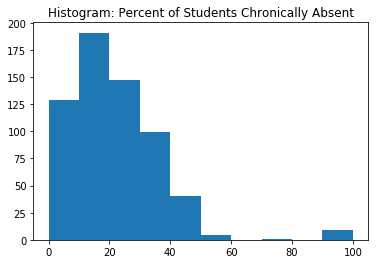

In [3]:
plt.figure(figsize = [6,4])
df_schools = df_schools.dropna(subset = ['Percent of Students Chronically Absent'])
df_schools['Percent of Students Chronically Absent'] = \
    [int(x.replace('%','')) for x in df_schools['Percent of Students Chronically Absent'].values]
plt.hist(df_schools['Percent of Students Chronically Absent'])
plt.title('Histogram: Percent of Students Chronically Absent')

In [4]:
df_schools[df_schools['Percent of Students Chronically Absent'] > 40]\
[['School Name', 'City', 'Percent of Students Chronically Absent']].sort_values('Percent of Students Chronically Absent', ascending = False)

,School Name,City,Percent of Students Chronically Absent
1261,SUCCESS ACADEMY CHARTER SCHOOL - BRONX 2,BRONX,100
1260,SUCCESS ACADEMY CHARTER SCHOOL - BRONX 1,BRONX,100
1206,SUCCESS ACADEMY CHARTER SCHOOL - UPPER WEST,NEW YORK,100
1203,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 5,NEW YORK,100
1198,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 4,NEW YORK,100
1197,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 3,NEW YORK,100
1196,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 2,NEW YORK,100
1173,BROOKLYN LAB CHARTER SCHOOL,BROOKLYN,100
1121,SUCCESS ACADEMY CHARTER SCHOOL - BED-STUY 1,BROOKLYN,100
300,NEW DIRECTIONS SECONDARY SCHOOL,BRONX,74


Resources:
